## Learning Python the Hard Way - Session 4
Toronto Data Literacy Group

Creator: Cindy Zhong

Date: April 4, 2017

In [1]:
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
edge_path = "../Lesson3/relations.csv"
edge = pd.read_csv(edge_path)

In [3]:
# Helper function for drawing networks
def draw_graph(g, size=18, community=None, title=None):
    """Plots a simple network graph using networkX
    Parameters
    ----------
    g : networkx.Graph
        the networkx graph which is decomposed
    size: int
        the size of the graph, optional
    commnity: dict, optional
        the partition of the nodes, i.e a dictionary where keys are their nodes and values the communities
    title: str, optional
        the title of the graph, optional
    """
    
    plt.figure(figsize=(size,size))
    graph = nx.DiGraph()
    pos=nx.spring_layout(g)
    
    # Assign color based on community label
    values = None
    if community > 0:
        values = [community.get(node) for node in g.nodes()]
    
    # render the graph
    nx.draw_networkx_nodes(g,pos,node_size=500,node_color=values, alpha=0.3,cmap = plt.get_cmap('jet'))
    nx.draw_networkx_edges(g,pos,width=1,alpha=0.5)
    nx.draw_networkx_labels(g,pos,font_size=12)
    
    if title:
        plt.title(title, fontsize=30)
    plt.axis('off')
    plt.show()

In [4]:
H = nx.Graph(name="World of Harry Potter")
for index, e in edge.iterrows():
    H.add_edge(e['source'],e['target'])

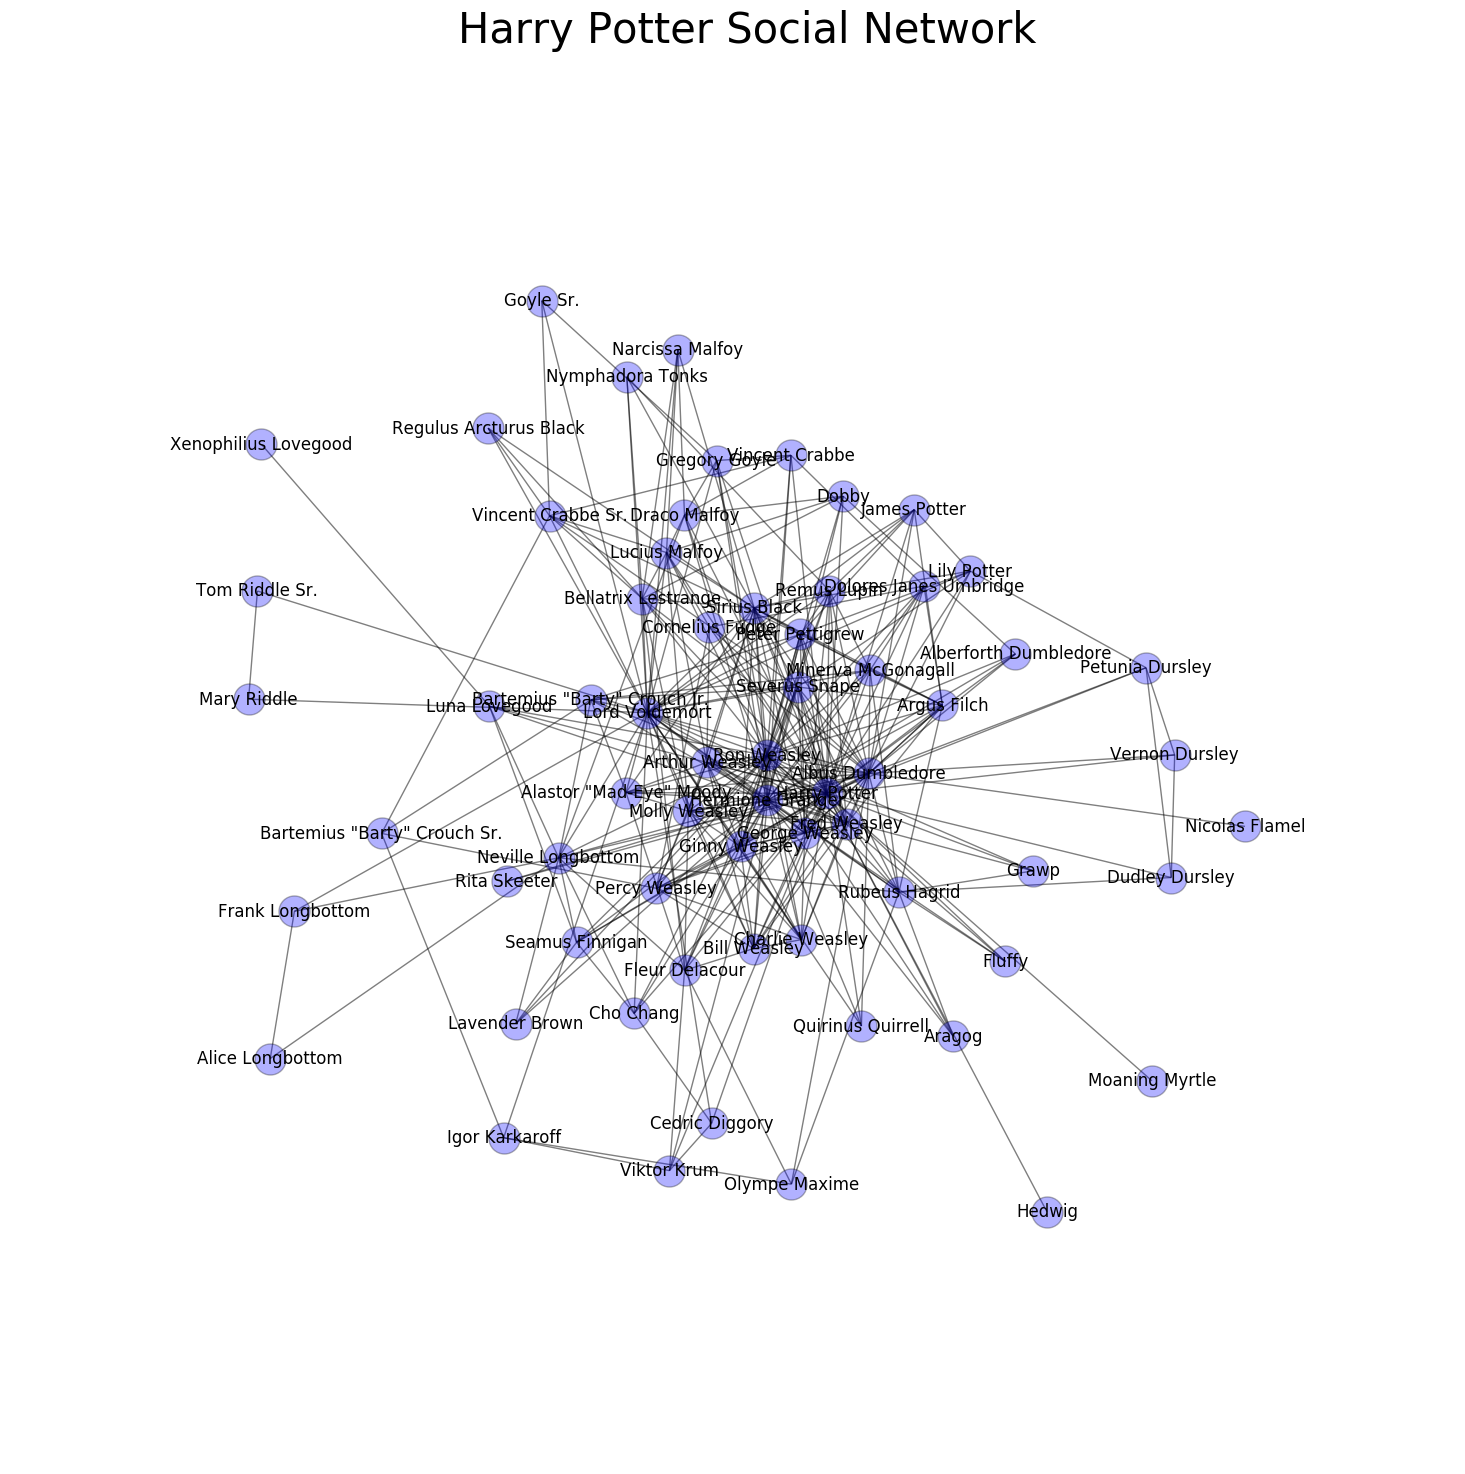

In [5]:
# Draw the Harry Potter Network
draw_graph(H,title = "Harry Potter Social Network")

Now we want to learn about the communities in the network.

Let's start with a sub-graph in the network

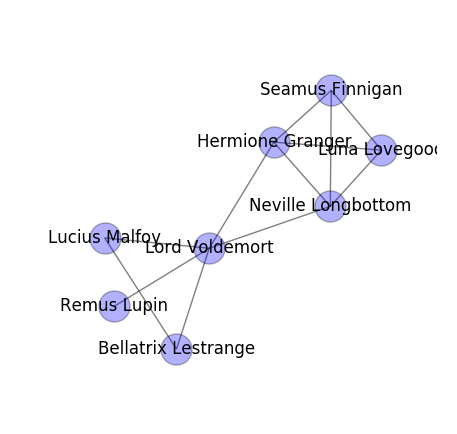

In [6]:
# Creating a subgraph
lh = H.subgraph(['Luna Lovegood','Hermione Granger','Neville Longbottom','Seamus Finnigan','Remus Lupin','Bellatrix Lestrange','Lord Voldemort','Lucius Malfoy'])
draw_graph(lh,size = 5)

#### Edge Betweenness Algorithm Implementation - A Simple Illustration
Let's implement the edge betweenness algorithm for the sub-graph

In [7]:
# Calculate the edge betweenness (the number of shortest paths pass along one edge) of all existing edges in the network
nx.edge_betweenness_centrality(lh)

{('Hermione Granger', 'Lord Voldemort'): 0.2857142857142857,
 ('Hermione Granger', 'Neville Longbottom'): 0.03571428571428571,
 ('Hermione Granger', 'Seamus Finnigan'): 0.10714285714285714,
 ('Lord Voldemort', 'Bellatrix Lestrange'): 0.21428571428571427,
 ('Lord Voldemort', 'Neville Longbottom'): 0.2857142857142857,
 ('Lord Voldemort', 'Remus Lupin'): 0.25,
 ('Lucius Malfoy', 'Bellatrix Lestrange'): 0.03571428571428571,
 ('Lucius Malfoy', 'Lord Voldemort'): 0.21428571428571427,
 ('Luna Lovegood', 'Hermione Granger'): 0.10714285714285714,
 ('Luna Lovegood', 'Neville Longbottom'): 0.10714285714285714,
 ('Luna Lovegood', 'Seamus Finnigan'): 0.03571428571428571,
 ('Seamus Finnigan', 'Neville Longbottom'): 0.10714285714285714}

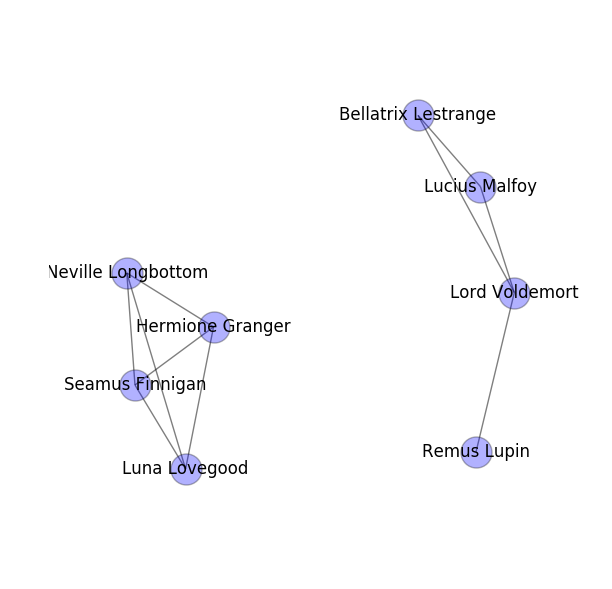

In [8]:
# Remove edge with highest betweenness
lh.remove_edge('Lord Voldemort','Hermione Granger')
lh.remove_edge('Lord Voldemort','Neville Longbottom')
draw_graph(lh,size = 7)

In [9]:
# Recalculate edge betweenness for all edges
nx.edge_betweenness_centrality(lh)

{('Hermione Granger', 'Neville Longbottom'): 0.03571428571428571,
 ('Hermione Granger', 'Seamus Finnigan'): 0.03571428571428571,
 ('Lord Voldemort', 'Bellatrix Lestrange'): 0.07142857142857142,
 ('Lord Voldemort', 'Remus Lupin'): 0.10714285714285714,
 ('Lucius Malfoy', 'Bellatrix Lestrange'): 0.03571428571428571,
 ('Lucius Malfoy', 'Lord Voldemort'): 0.07142857142857142,
 ('Luna Lovegood', 'Hermione Granger'): 0.03571428571428571,
 ('Luna Lovegood', 'Neville Longbottom'): 0.03571428571428571,
 ('Luna Lovegood', 'Seamus Finnigan'): 0.03571428571428571,
 ('Seamus Finnigan', 'Neville Longbottom'): 0.03571428571428571}

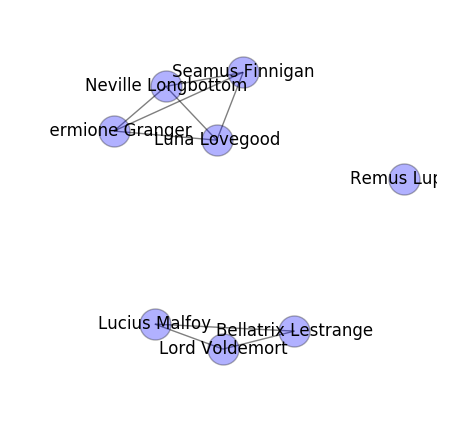

In [10]:
# Remove the edge with the highest edge betweenness
lh.remove_edge('Lord Voldemort','Remus Lupin')
draw_graph(lh,size = 5)

#### Edge Betweenness Algorithm Implementation - Algorithm Steps
Let's now put the steps above into a function

In [11]:
# wrapping the steps above in a function
def edge_betweenness_step(G):
    init_ncomp = nx.number_connected_components(G)    # no of components
    ncomp = init_ncomp
    while ncomp <= init_ncomp:
        bw = nx.edge_betweenness_centrality(G)    #calculate the edge betweenness in graph G
        # find the edge with max centrality
        max_ = max(bw.values())
#        print 'Max edge betweenness values is:  %f' %max_
        # find the edge with the highest centrality and remove all of them if there is more than one!
        for k, v in bw.iteritems():
            if float(v) == max_:
                G.remove_edge(k[0],k[1])    # remove the central edge
        ncomp = nx.number_connected_components(G)    # recalculate the no of components

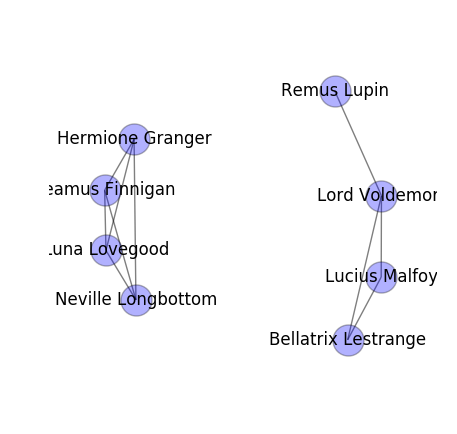

In [12]:
lh = H.subgraph(['Luna Lovegood','Hermione Granger','Neville Longbottom','Seamus Finnigan','Remus Lupin','Bellatrix Lestrange','Lord Voldemort','Lucius Malfoy'])
edge_betweenness_step(lh)
draw_graph(lh,size=5)

#### Edge Betweenness Algorithm Implementation - Modularity Optimization

In [13]:
def get_modularity(G,orig_deg,m_edge):
    A = nx.adj_matrix(G) #putting the graph in an adjacency matrix
    nodes = G.nodes() #number of nodes in the graph
    n = len(nodes)
    new_deg = {}
    B = A.sum(axis = 1)
    for i in range(n):
        new_deg[nodes[i]] = B[i, 0]
    #Let's compute the modularity of our graph
    comps = nx.connected_components(G)    #list of components
    mod = 0    #Modularity of a given partitionning
    for c in comps:
        EWC = 0    #no of edges within a community
        RE = 0    #no of random edges
        for u in c:
            EWC += new_deg[u]
            RE += orig_deg[u]        #count the probability of a random edge
        mod += ( float(EWC) - float(RE*RE)/float(2*m_edge) )
    mod = mod/float(2*m_edge)
    return mod

0.0
0.48
0.444444444444


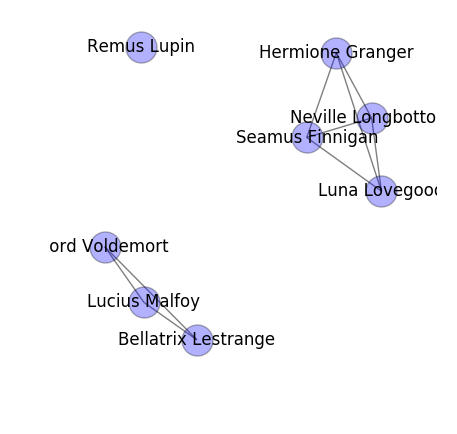

In [14]:
lh = H.subgraph(['Luna Lovegood','Hermione Granger','Neville Longbottom','Seamus Finnigan','Remus Lupin','Bellatrix Lestrange','Lord Voldemort','Lucius Malfoy'])
print get_modularity(lh,nx.degree(lh),lh.size())
edge_betweenness_step(lh)
print get_modularity(lh,nx.degree(lh),lh.size())
edge_betweenness_step(lh)
print get_modularity(lh,nx.degree(lh),lh.size())
draw_graph(lh,size=5)

In [15]:
def run_eb_step(G):
    #let's find the best split of the graph
    #Initialization of the modularity
    best_mod = 0.0
    orig_deg = nx.degree(G)
    m_edge = G.size()
    cur_mod = get_modularity(G, orig_deg, m_edge)
    print "Modularity of original G: %f" % cur_mod
    print 'Start decomposing G using Edge Betweenness Algorithm ...'
    
    #repeat the edge_betweenness_step until the modularity measure no long improves
    while True:
        new_G = G #keep a copy of the graph
        edge_betweenness_step(new_G) # apply edge_betwennes_step to my new_G
        # Get out of the loop if no more edge remains
        if new_G.number_of_edges() == 0:
            break
        else:
            cur_mod = get_modularity(new_G,orig_deg, m_edge) #update the modularity measure
            print "Modularity of updated G: %f" % cur_mod
            ncomp = nx.number_connected_components(new_G) # calculate the number of components
            print "Number of components in the updated G: %d" % ncomp

In [16]:
lh = H.subgraph(['Luna Lovegood','Hermione Granger','Neville Longbottom','Seamus Finnigan','Remus Lupin','Bellatrix Lestrange','Lord Voldemort','Lucius Malfoy'])
run_eb_step(lh)

Modularity of original G: 0.000000
Start decomposing G using Edge Betweenness Algorithm ...
Modularity of updated G: 0.319444
Number of components in the updated G: 2
Modularity of updated G: 0.267361
Number of components in the updated G: 3


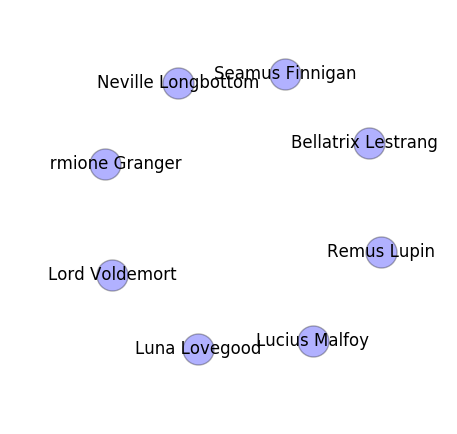

In [17]:
draw_graph(lh,size=5)

#### Louvain Method
For a faster algorithm, We have a very easy to use implementation of Louvain Method

pip install python-louvain

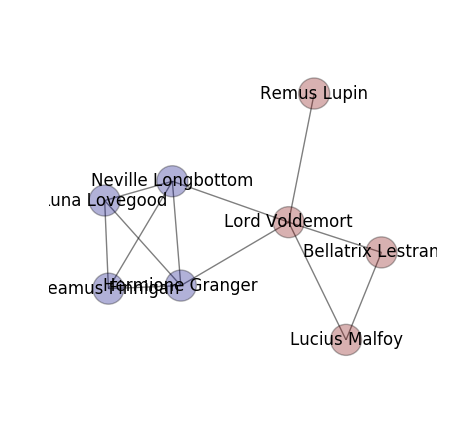

In [19]:
import community
lh = H.subgraph(['Luna Lovegood','Hermione Granger','Neville Longbottom','Seamus Finnigan','Remus Lupin','Bellatrix Lestrange','Lord Voldemort','Lucius Malfoy'])
part = community.best_partition(lh)
draw_graph(lh,size=5,community=part)

In [20]:
mod = community.modularity(part,lh)
print("modularity:", mod)

('modularity:', 0.3194444444444443)


In [21]:
# Draw the Harry Potter Network with Community
import community
part = community.best_partition(H)

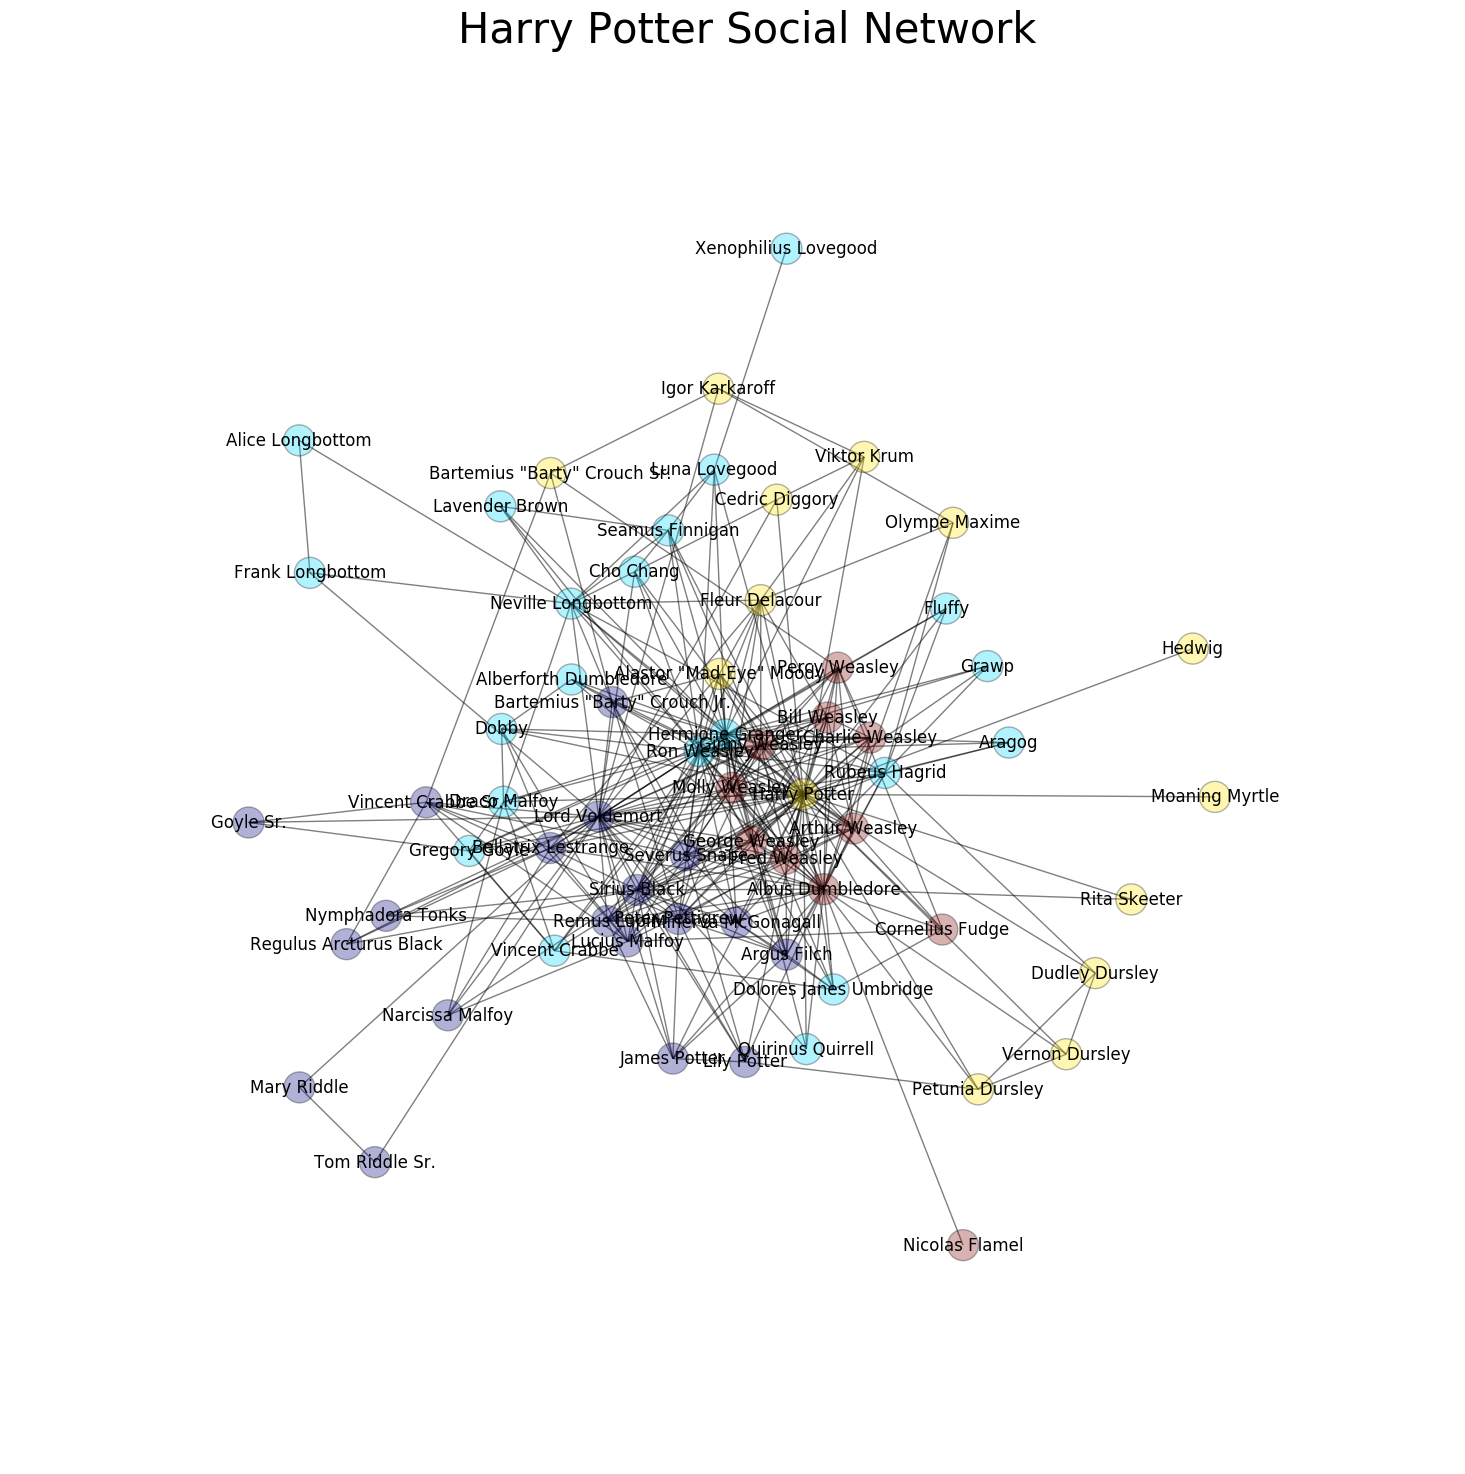

In [22]:
draw_graph(H,community=part, title = "Harry Potter Social Network")

In [23]:
mod = community.modularity(part,H)
print("modularity:", mod)

('modularity:', 0.25775324874423977)
